In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.metrics import roc_auc_score,classification_report, recall_score, f1_score,precision_recall_curve, auc,precision_score
import multiprocessing
from pycaret.classification import *
from xgboost import XGBClassifier,XGBRFClassifier

In [2]:
df = pd.read_csv('Data_preprocessing_v4.csv')

In [3]:
df.shape

(23107, 20)

In [4]:
df.head()

,id,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HISPAN_I,HYPEV,HYPMDEV2,HYPMED2,INTIL2W,MRACBPI2,MRACRPI2,REGION,HEIGHT(cm),WEIGHT(kg),DIBEV1
0,100011,79.0,0.0,1.0,23.594147,1.0,0.0,0,1.0,12.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,157.48,58.513368,1
1,100061,37.0,0.0,0.0,32.775484,1.0,0.0,0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,180.34,106.594120,0
2,100091,75.0,0.0,1.0,22.273536,1.0,0.0,1,0.0,12.0,1.0,1.0,1.0,0.0,7.0,11.0,3.0,167.64,62.595696,0
3,1000101,39.0,0.0,0.0,23.709925,0.0,0.0,0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,180.34,77.110640,0
4,1000131,54.0,1.0,0.0,38.273579,1.0,0.0,0,1.0,12.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,165.10,104.326160,0


In [5]:
df.shape

(23107, 20)

In [6]:
df.DIBEV1.value_counts()

0    19865
1     3242
Name: DIBEV1, dtype: int64

In [7]:
df.DIBEV1.value_counts()[0]/(df.DIBEV1.value_counts()[0]+df.DIBEV1.value_counts()[1])

0.8596961959579348

In [8]:
X_tr, X_test, y_tr, y_test = train_test_split(df.drop(['id','DIBEV1'],axis=1),df['DIBEV1'],shuffle=True,test_size=0.05,stratify=df['DIBEV1'])

In [9]:
y_tr.value_counts()[0]/(y_tr.value_counts()[0]+y_tr.value_counts()[1])

0.8596874857637465

In [10]:
y_tr.value_counts()

0    18871
1     3080
Name: DIBEV1, dtype: int64

In [11]:
y_test.value_counts()

0    994
1    162
Name: DIBEV1, dtype: int64

In [12]:
X_tr.shape

(21951, 18)

In [13]:
sampler = RandomUnderSampler(random_state=123)

In [14]:
y_tr.value_counts()

0    18871
1     3080
Name: DIBEV1, dtype: int64

In [15]:
X_under , y_under = sampler.fit_resample(X_tr,y_tr)
print(y_under.value_counts())

0    3080
1    3080
Name: DIBEV1, dtype: int64


## 1. 수치형 변수 데이터 스케일링

In [16]:
# 스케일링을 적용할 컬럼 선정
num_col = ['AGE','BMI','HEIGHT(cm)','WEIGHT(kg)']

In [17]:
# 전체 데이터셋의 위 컬럼들에 대해 스케일링 fit 후 각 데이터셋 및 검증용 데이터셋에 transform 적용
for col in num_col:
    ss = StandardScaler()
    X_under[col] = ss.fit_transform(X_under[[col]])
    X_test[col] = ss.transform(X_test[[col]])

## 2. unique 개수가 3개 이상인 컬럼들 onehotencoding

In [18]:
# 데이터프레임 전체 컬럼에서 수치형 컬럼 제외
cols = np.setdiff1d(X_under.columns,num_col)

# 위 컬럼에서 고유값 개수가 3개 이상인 컬럼만 추출
# 0,1만 가지는 binary 컬럼은 굳이 ohe를 하지 않을 것
nom_col = [col for col in cols if X_under[col].nunique() >= 3 ]

In [19]:
nom_col

['HISPAN_I', 'MRACBPI2', 'MRACRPI2', 'REGION']

In [20]:
# 명목형 컬럼들에 대한 dummy 데이터 생성(원핫인코딩)
train_dummies = [] # 학습용 데이터셋의 명목형 컬럼들의 더미데이터셋 저장용 리스트
test_dummies = [] # 검증용 데이터셋의 명목형 컬럼들의 더미데이터셋 저장용 리스트
for col in nom_col:
    train_dummies.append(pd.get_dummies(X_under[col],prefix=col,dummy_na=True,dtype='float')) # 학습데이터의 각 컬럼들의 더미데이터셋을 리스트에 저장
    test_dummies.append(pd.get_dummies(X_test[col],prefix=col,dummy_na=True,dtype='float')) # 검증데이터의 각 컬럼들의 더미데이터셋을 리스트에 저장

In [21]:
train_dummies = pd.concat(train_dummies,axis=1) # 학습 데이터의 더미데이터셋 리스트를 하나로 합침
test_dummies = pd.concat(test_dummies,axis=1) # 검증 데이터의 더미데이터셋 리스트를 하나로 합침

In [22]:
train_dummies.shape, test_dummies.shape

((6160, 35), (1156, 34))

In [23]:
# 만약 고유값 개수 차이로 인해 학습셋과 테스트셋의 더미 데이터셋 컬럼 차이가 있다면 컬럼수를 통일
# 학습 및 예측 오류 방지

if train_dummies.columns.nunique() > test_dummies.columns.nunique():
    missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
    for col in missing_cols:
        test_dummies[col] = 0
elif train_dummies.columns.nunique() < test_dummies.columns.nunique():
    missing_cols = set(test_dummies.columns) - set(train_dummies.columns)
    for col in missing_cols:
        train_dummies[col] = 0
else:
    pass

In [24]:
train_dummies.shape, test_dummies.shape

((6160, 35), (1156, 35))

In [25]:
# 원본의 학습,테스트셋에 더미데이터셋 합친 후 기존 명목형 컬럼 제거
X_under = pd.concat([X_under,train_dummies],axis=1).drop(nom_col,axis=1)
X_test = pd.concat([X_test,test_dummies],axis=1).drop(nom_col,axis=1)

In [26]:
X_under.shape, X_test.shape

((6160, 49), (1156, 49))

In [27]:
X_under.shape, y_under.shape

((6160, 49), (6160,))

In [28]:
X_tr, X_val, y_tr, y_val = train_test_split(X_under,y_under,test_size=0.2,random_state=123,shuffle=True,stratify=y_under)

# pycaret 최적화 모델링

In [29]:
clf = setup(data=X_tr,target=y_tr,preprocess=False,verbose=False,n_jobs=-1,session_id=123) # pycaret AutoML사용을 위한 초기화
best_5 = compare_models(fold=10, sort='f1',verbose=True,n_select=5) # pycaret에서 F1 score기준으로 데이터셋에 최적화된 모델 1개 선정(n_select = 1이 기본값이며, 이 값에 따라 선정되는 모델의 개수 변경 됨)
# 각 데이터셋에 최적화된 모델 5개 중 predict_proba 메소드가 없는 모델 제거
tuned_models = []
for model in best_5:
    tuned_model = tune_model(model,optimize='f1',verbose=False)
    tuned_models.append(tuned_model)
tuned_models_copy = tuned_models.copy()
for model in tuned_models_copy:
    try : 
        blend_models(estimator_list=[model], method='soft',verbose=False)
    except:
        tuned_models.remove(model)
ensemble_model = blend_models(estimator_list=tuned_models, method='soft',optimize='f1',verbose=False) # best_5 모델들에 대한 앙상블

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7382,0.8045,0.7467,0.7350,0.7401,0.4764,0.4773,0.2960
gbc,Gradient Boosting Classifier,0.7330,0.7976,0.7559,0.7233,0.7383,0.4659,0.4678,0.0620
ada,Ada Boost Classifier,0.7338,0.7934,0.7478,0.7280,0.7372,0.4676,0.4686,0.0300
ridge,Ridge Classifier,0.7356,0.0000,0.7409,0.7337,0.7368,0.4711,0.4718,0.0070
lda,Linear Discriminant Analysis,0.7350,0.8038,0.7403,0.7331,0.7363,0.4700,0.4706,0.0100
lightgbm,Light Gradient Boosting Machine,0.7101,0.7756,0.7397,0.6993,0.7181,0.4201,0.4220,0.0640
rf,Random Forest Classifier,0.7124,0.7786,0.7287,0.7066,0.7168,0.4248,0.4258,0.0680
xgboost,Extreme Gradient Boosting,0.7005,0.7617,0.7177,0.6954,0.7050,0.4010,0.4028,0.0350
et,Extra Trees Classifier,0.6982,0.7564,0.7026,0.6981,0.6997,0.3964,0.3971,0.0620
knn,K Neighbors Classifier,0.6892,0.7424,0.6748,0.6961,0.6841,0.3784,0.3797,0.1570


In [30]:
ensemble_model

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.056, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Gradient Boosting Classifier',
                              GradientBoostingClassifier(ccp_a...
                                                 base_estimator='deprecated',
                                                 estimator=None,
                                                 learning_rate=0.2,
                                                 n_estimators=230,
                                                 random_state=123)),
                             ('Linear Discriminant Analysis',
                              LinearDiscriminantAnalysis(covariance_estimator=None,
                                                         n_components=None,
                                                         priors=None,
                                                         shrinkage=0.2,
                                                         solver='eigen',
                                                         store_covariance=False,
                                                         tol=0.0001))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [31]:
tuned_models[2].feature_names_in_

array(['AGE', 'ALCSTAT', 'ARTH1', 'BMI', 'CHLEV', 'EPHEV', 'FSBALANC',
       'GENDER', 'HYPEV', 'HYPMDEV2', 'HYPMED2', 'INTIL2W', 'HEIGHT(cm)',
       'WEIGHT(kg)', 'HISPAN_I_0.0', 'HISPAN_I_1.0', 'HISPAN_I_2.0',
       'HISPAN_I_3.0', 'HISPAN_I_4.0', 'HISPAN_I_5.0', 'HISPAN_I_6.0',
       'HISPAN_I_7.0', 'HISPAN_I_8.0', 'HISPAN_I_12.0', 'HISPAN_I_nan',
       'MRACBPI2_1.0', 'MRACBPI2_2.0', 'MRACBPI2_3.0', 'MRACBPI2_6.0',
       'MRACBPI2_7.0', 'MRACBPI2_12.0', 'MRACBPI2_16.0', 'MRACBPI2_17.0',
       'MRACBPI2_nan', 'MRACRPI2_1.0', 'MRACRPI2_2.0', 'MRACRPI2_3.0',
       'MRACRPI2_9.0', 'MRACRPI2_10.0', 'MRACRPI2_11.0', 'MRACRPI2_15.0',
       'MRACRPI2_16.0', 'MRACRPI2_17.0', 'MRACRPI2_nan', 'REGION_1.0',
       'REGION_2.0', 'REGION_3.0', 'REGION_4.0', 'REGION_nan'],
      dtype=object)

In [32]:
tuned_models[2].feature_names_in_[tuned_models[2].feature_importances_ >= 0.05]

array(['AGE', 'BMI', 'HEIGHT(cm)', 'WEIGHT(kg)'], dtype=object)

In [33]:
# 앙상블 모델을 최종 한개의 모델로 마지막 학습 / cross_val 사용
final_model = finalize_model(ensemble_model)

In [34]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 VotingClassifier(estimators=[('Logistic Regression',
                                               LogisticRegression(C=0.056,
                                                                  class_weight={},
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=...
                                                                  base_estimator='deprecated',
                                                                  estimator=None,
                                                                  learning_rate=0.2,
                                                                  n_estimators=230,
                                                                  random_state=123)),
                                              ('Linear Discriminant Analysis',
                                               LinearDiscriminantAnalysis(covariance_estimator=None,
                                                                          n_components=None,
                                                                          priors=None,
                                                                          shrinkage=0.2,
                                                                          solver='eigen',
                                                                          store_covariance=False,
                                                                          tol=0.0001))],
                                  flatten_transform=True, n_jobs=-1,
                                  verbose=False, voting='soft',
                                  weights=None))],
         verbose=False)

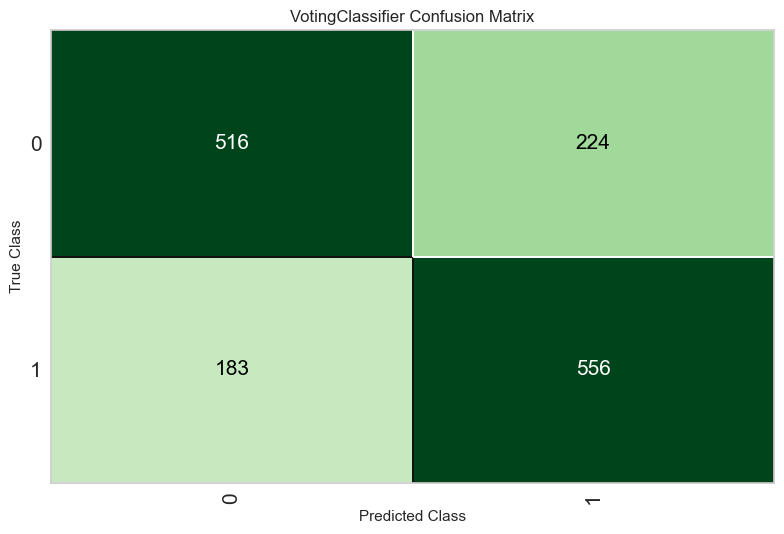

In [35]:
plot_model(final_model,plot='confusion_matrix')

In [36]:
# 검증 예측
pred = predict_model(final_model,data=X_val,verbose=True)

In [37]:
final_model.predict_proba(X_val)

array([[0.4702694 , 0.5297306 ],
       [0.27567769, 0.72432231],
       [0.65999339, 0.34000661],
       ...,
       [0.71837228, 0.28162772],
       [0.70043265, 0.29956735],
       [0.34578209, 0.65421791]])

In [38]:
pred

,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HYPEV,HYPMDEV2,...,MRACRPI2_16.0,MRACRPI2_17.0,MRACRPI2_nan,REGION_1.0,REGION_2.0,REGION_3.0,REGION_4.0,REGION_nan,prediction_label,prediction_score
7662,0.075257,0.0,1.0,0.585373,0.0,0.0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0.5297
22367,0.758257,0.0,1.0,1.131129,1.0,0.0,1,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.7243
1058,0.189091,0.0,0.0,-0.658912,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.6600
12550,0.530590,0.0,1.0,-0.782028,1.0,0.0,1,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.6959
19943,-0.721575,1.0,0.0,0.702564,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.5947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,-0.152409,0.0,1.0,-0.250956,1.0,0.0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.5905
17143,-0.721575,0.0,0.0,0.553687,1.0,0.0,0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.5830
9123,-2.201407,1.0,0.0,-1.299042,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.7184
4706,-1.518408,1.0,0.0,-0.438953,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.7004


In [39]:
# 실제값 과 예측값 비교
print(classification_report(y_val,pred['prediction_label']))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       616
           1       0.73      0.76      0.74       616

    accuracy                           0.74      1232
   macro avg       0.74      0.74      0.74      1232
weighted avg       0.74      0.74      0.74      1232



In [40]:
precision_score(y_val,pred['prediction_label'])

0.7282608695652174

In [41]:
recall_score(y_val,pred['prediction_label'])

0.7613636363636364

In [42]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # thredshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출 
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 thredshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시 
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label ='recall')
    
    #thredshold 값 X축 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    #X축, y축, label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

In [43]:
pred['predict_proba'] = pred['prediction_score']
pred.loc[pred['prediction_label']==0,'predict_proba'] = 1-pred.loc[pred['prediction_label']==0,'predict_proba']

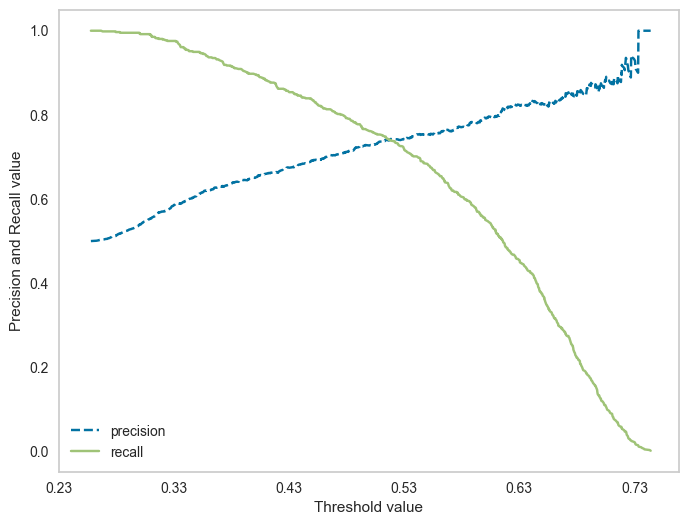

In [44]:
precision_recall_curve_plot(y_val,pred['predict_proba'])

In [45]:
f1_score_list = []
threshold_list = []
for j in range(10):
    j = 0.45+j*0.01
    # j = 0.485
    result = [0 if i<=j else 1 for i in pred['predict_proba']]
    score = f1_score(y_val,result)
    f1_score_list.append(score)
    threshold_list.append(j)
    print(f'임계값:{j} / f1_score : {score} / recall : {recall_score(y_val,result)} / precision : {precision_score(y_val,result)}')

임계값:0.45 / f1_score : 0.7567964731814842 / recall : 0.836038961038961 / precision : 0.6912751677852349
임계값:0.46 / f1_score : 0.751497005988024 / recall : 0.814935064935065 / precision : 0.6972222222222222
임계값:0.47000000000000003 / f1_score : 0.7515151515151516 / recall : 0.8051948051948052 / precision : 0.7045454545454546
임계값:0.48 / f1_score : 0.7501921598770178 / recall : 0.7922077922077922 / precision : 0.7124087591240876
임계값:0.49 / f1_score : 0.7496087636932707 / recall : 0.7775974025974026 / precision : 0.7235649546827795
임계값:0.5 / f1_score : 0.7444444444444445 / recall : 0.7613636363636364 / precision : 0.7282608695652174
임계값:0.51 / f1_score : 0.7437751004016064 / recall : 0.7516233766233766 / precision : 0.7360890302066773
임계값:0.52 / f1_score : 0.7400162999185005 / recall : 0.737012987012987 / precision : 0.7430441898527005
임계값:0.53 / f1_score : 0.7293729372937294 / recall : 0.7175324675324676 / precision : 0.7416107382550335
임계값:0.54 / f1_score : 0.7260504201680672 / recall : 0.

In [46]:
j = 0.505
# j = 0.485
result = [0 if i<=j else 1 for i in pred['predict_proba']]
score = f1_score(y_val,result)
f1_score_list.append(score)
threshold_list.append(j)
print(f'임계값:{j} / f1_score : {score} / recall : {recall_score(y_val,result)} / precision : {precision_score(y_val,result)}')

임계값:0.505 / f1_score : 0.7422186751795691 / recall : 0.7548701298701299 / precision : 0.7299843014128728


# 테스트 데이터

In [47]:
# 검증 예측
pred = predict_model(final_model,data=X_test,verbose=True)

In [48]:
pred

,AGE,ALCSTAT,ARTH1,BMI,CHLEV,EPHEV,FSBALANC,GENDER,HYPEV,HYPMDEV2,...,MRACRPI2_17.0,MRACRPI2_nan,REGION_1.0,REGION_2.0,REGION_3.0,REGION_4.0,REGION_nan,HISPAN_I_7.0,prediction_label,prediction_score
20014,-0.607742,0.0,0.0,0.516837,1.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.5196
21999,-0.380075,0.0,0.0,-0.786938,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.6663
18840,-1.461491,1.0,0.0,0.379484,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6737
3169,0.246007,0.0,0.0,-1.549367,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.6869
2573,0.132174,0.0,1.0,0.062350,1.0,1.0,0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.6339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,-0.949242,0.0,0.0,-1.093777,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.7091
20055,0.530590,0.0,1.0,1.408041,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.5146
18031,-0.436992,0.0,0.0,-0.802510,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.6932
9941,-1.689158,0.0,1.0,-0.590032,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.6944


In [49]:
# 실제값 과 예측값 비교
print(classification_report(y_test,pred['prediction_label']))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83       994
           1       0.32      0.78      0.46       162

    accuracy                           0.74      1156
   macro avg       0.64      0.76      0.64      1156
weighted avg       0.87      0.74      0.78      1156



In [50]:
precision_score(y_test,pred['prediction_label'])

0.3248081841432225

In [51]:
recall_score(y_test,pred['prediction_label'])

0.7839506172839507

In [52]:
pred['predict_proba'] = pred['prediction_score']
pred.loc[pred['prediction_label']==0,'predict_proba'] = 1-pred.loc[pred['prediction_label']==0,'predict_proba']

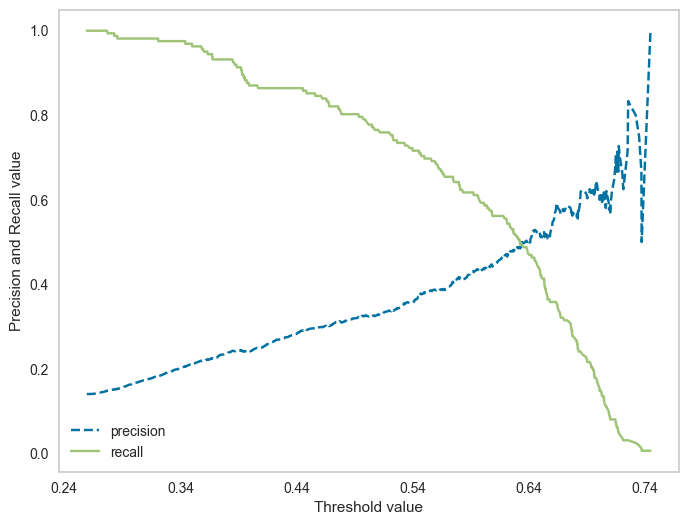

In [53]:
precision_recall_curve_plot(y_test,pred['predict_proba'])

In [54]:
result = [0 if i<=j else 1 for i in pred['predict_proba']]

In [55]:
print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       994
           1       0.32      0.77      0.46       162

    accuracy                           0.74      1156
   macro avg       0.64      0.76      0.64      1156
weighted avg       0.86      0.74      0.78      1156



In [56]:
precision_score(y_test,result)

0.3246753246753247

In [57]:
recall_score(y_test,result)

0.7716049382716049